In [1]:
# !pip install torch torchvision torchaudio
# !pip install torchviz

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

*Source Book - Time Series Forecasting Using Deep Learning*

Concept of RNN:

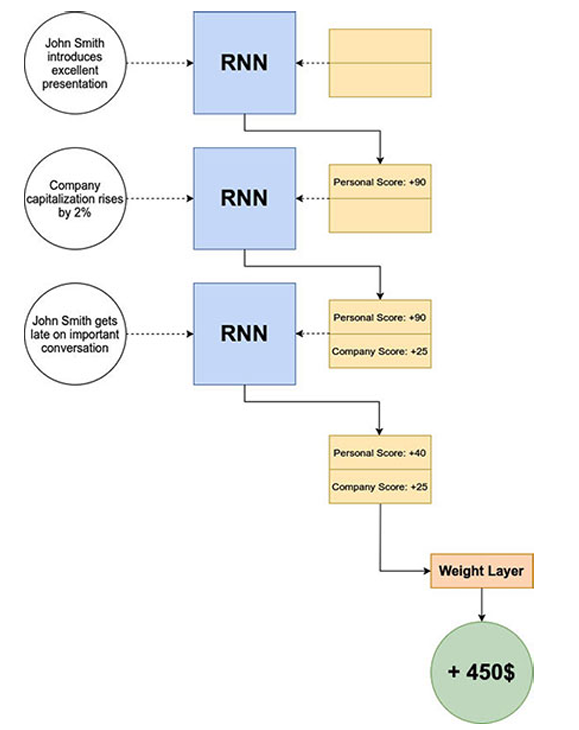

In [2]:
from IPython import display
display.Image("RNN .png")

Remember prediction before

Flow of RNN

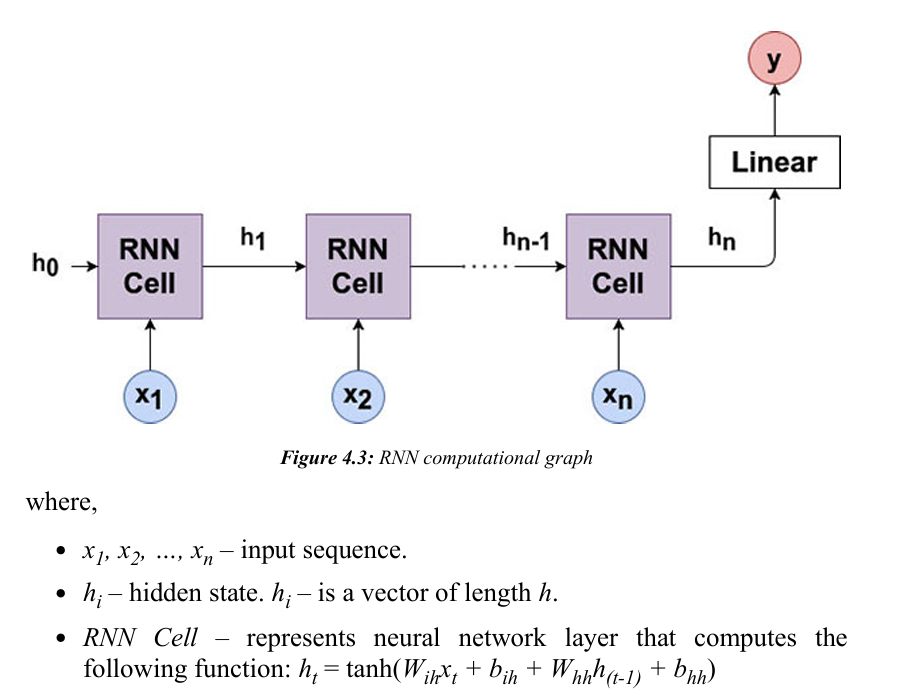

In [3]:
display.Image("flow RNN.png")

For detail of RNN Cell

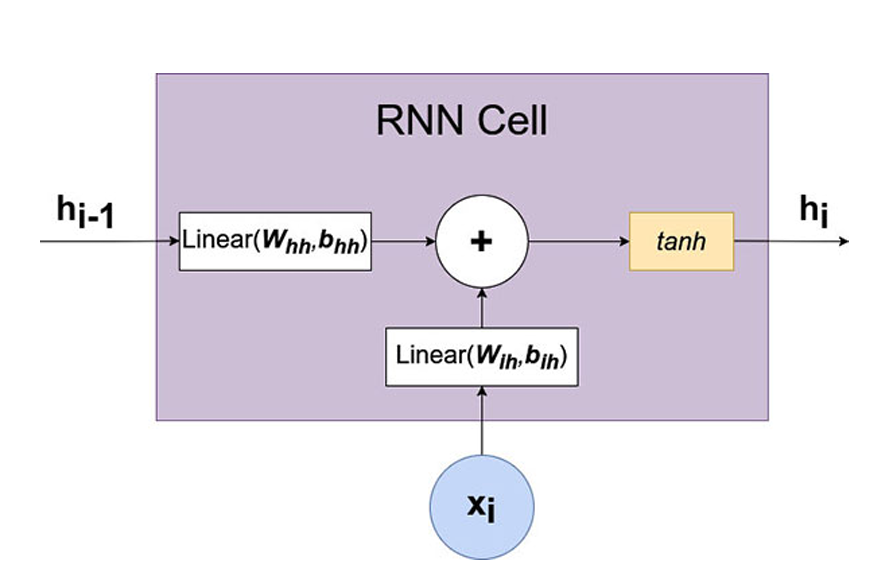

In [4]:
display.Image("rnn cell.png")

Where:
- Wih – input-hidden weights
- bih – input-hidden bias
- Whh – hidden-hidden weights
- bhh – hidden-hidden bias

In [3]:
# lets code

def load_data(data):
    """Load a Data"""

    # read data
    data = pd.read_csv(data)
    print('Data before drop duplicated', data.shape)

    # drop duplicated
    data = data.drop_duplicates(keep='first')
    print('Data after drop duplicated', data.shape)

    return data

In [4]:
data = load_data('/content/AEP_hourly.csv')
data.head(2)

Data before drop duplicated (121273, 2)
Data after drop duplicated (121273, 2)


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0


In [5]:
# create activation with scratch
def tanh(x):
    """Activation tanh"""
    exp_x = torch.exp(x)
    exp_minus_x = torch.exp(-x)
    res_tanh = (exp_x - exp_minus_x) / (exp_x + exp_minus_x)

    return res_tanh

# validation
data_dummy = torch.tensor([0.0, 1.0, 2.0, 3.0, 4.0])

# with scratch
print('result scratch:', tanh(data_dummy))

# with module
print('result module:', torch.tanh(data_dummy))

result scratch: tensor([0.0000, 0.7616, 0.9640, 0.9951, 0.9993])
result module: tensor([0.0000, 0.7616, 0.9640, 0.9951, 0.9993])


In [6]:
import torch.nn as nn

class RNNScratch(nn.Module):

    def __init__(self, hidden_size, input_size=1, output_size=1):
        super(RNNScratch, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        # initialize weights
        self.Whi = nn.Parameter(torch.randn(input_size, hidden_size)) # weight hidden input
        self.Whh = nn.Parameter(torch.randn(hidden_size, hidden_size)) # weight hidden hidden
        self.Who = nn.Parameter(torch.randn(hidden_size, output_size)) # weight hidden output

        # initialize bias
        self.bh = nn.Parameter(torch.zeros(1, hidden_size)) # bias hidden
        self.bo = nn.Parameter(torch.zeros(1, output_size)) # bias output

    def tanh(self, x):
        """Activation tanh"""
        exp_x = torch.exp(x)
        exp_minus_x = torch.exp(-x)
        res_tanh = (exp_x - exp_minus_x) / (exp_x + exp_minus_x)
        return res_tanh

    def forward(self, inputs, h_previous=None):
        """
        Forward pass of the RNN cell
        """
        # Define weight input
        weight_input = torch.matmul(inputs.float(), self.Whi)

        # Define weight hidden hidden
        if h_previous is not None:
            weight_hidden = torch.matmul(h_previous.float(), self.Whh)
        else:
            # Initialize as zeros with the same shape as inputs
            weight_hidden = torch.zeros_like(inputs)

        # Next hidden state
        h_next = self.tanh(weight_input + weight_hidden + self.bh)

        # Output from hidden state
        output = torch.matmul(h_next, self.Who) + self.bo.float()

        # Take the last output and hidden state
        output = output[:, -1]
        h_next = h_next[:, -1]

        return output, h_next

In [7]:
# Example
x = torch.tensor([[[1.0], [2.0], [3.0]], [[4.0], [5.0], [6.0]]])
y = torch.tensor([[4.0], [7.0]])

# Inisialisasi model
hidden_size = 2
rnn_model = RNNScratch(hidden_size)

# test
output, last_hidden_states = rnn_model(x)

print("Output shape Scratch:", output.shape)
print("Last hidden states shape Scratch:", last_hidden_states.shape)

Output shape Scratch: torch.Size([2, 1])
Last hidden states shape Scratch: torch.Size([2, 2])


In [8]:
# class module NN
class RNN(nn.Module):
    def __init__(self, hidden_size, in_size=1, out_size=1):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=in_size,
            hidden_size=hidden_size,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
        out, _ = self.rnn(x, h)
        last_hidden_states = out[:, -1]
        out = self.fc(last_hidden_states)
        return out, last_hidden_states

In [9]:
# validation with module nn

# Inisialisasi model
hidden_size = 2
rnn_model = RNN(hidden_size)

# test
output, last_hidden_states = rnn_model(x)

print("Output shape module nn:", output.shape)
print("Last hidden states shape module nn:", last_hidden_states.shape)

Output shape module nn: torch.Size([2, 1])
Last hidden states shape module nn: torch.Size([2, 2])


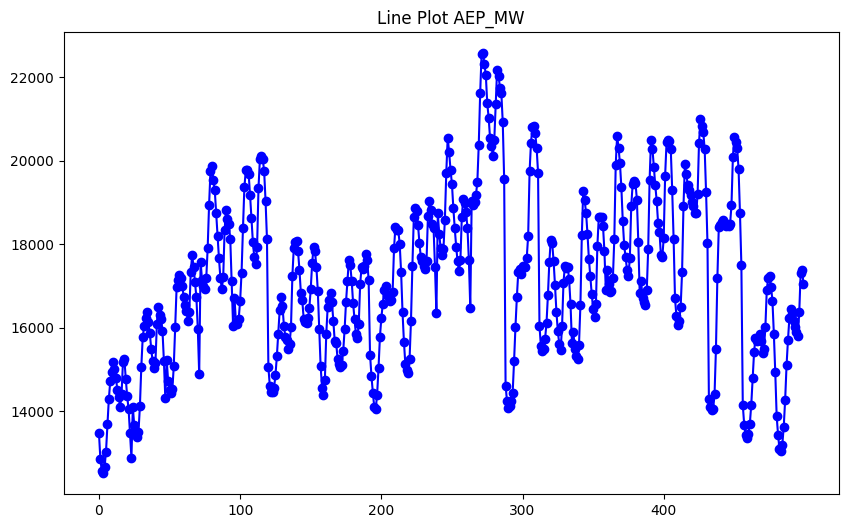

In [10]:
# visualize data
plt.figure(figsize=(10, 6))
plt.plot(range(len(data['AEP_MW'].head(500))),
         data['AEP_MW'].head(500),
         marker='o', color='b')

plt.title('Line Plot AEP_MW')
plt.xlabel('')
plt.ylabel('')
plt.xticks(range(0, 500, 100))
plt.show()

Normalize data with MinMaxscaller

In [11]:
# scratch MinMaxScaller
class MinMaxScaler():

  def __init__(self):
      """Initialize"""
      self.min = None # fill with min data
      self.max = None # fill with max data

  def fit(self, data):
      """Fitting initialize min max"""
      self.min = data.min(axis = 0) # obtain min by each columns
      self.max = data.max(axis = 0) # obtain max by each columns

  def transform(self, data):
      """Transform data"""
      x = data - self.min
      y = self.max - self.min
      transform = x / y

      return transform

  def fit_transform(self, data):
      """Fitting transform to data"""
      self.fit(data)
      return self.transform(data)

In [12]:
from sklearn.preprocessing import MinMaxScaler

# compare with module sklearn
data_mm = np.array([[1, 2, 3],
                    [4, 5, 6],
                    [7, 8, 9]])

# Scaler
scaler = MinMaxScaler()

# transform data
print("Scratch MinMaxScaler: \n", scaler.fit_transform(data_mm))

# Scaler dari sklearn
scaler_sklearn = MinMaxScaler()

# transform data
print("Sklearn MinMaxScaler: \n",scaler_sklearn.fit_transform(data_mm))

Scratch MinMaxScaler: 
 [[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]
Sklearn MinMaxScaler: 
 [[0.  0.  0. ]
 [0.5 0.5 0.5]
 [1.  1.  1. ]]


Sliding show for obtain target and predictor

![sliding window](https://drive.google.com/uc?id=1SIBOP_ZCatBf7aqV4K8loDQW3Gbuxzfd)


In [13]:
def interpolated_time_series():
    """convert data datetime to index"""

    # select data
    data_subset = data.head(20000).copy()  # Copy the subset to avoid SettingWithCopyWarning

    # change datetime
    data_subset.loc[:, 'Datetime'] = pd.to_datetime(data_subset['Datetime'])

    # create index by Datetime
    data_subset.set_index('Datetime', inplace=True)

    return data_subset

def sliding_window(ts, features):
    """
    Sliding window for obtain predictor and target

    Paramaters:
    -----------
      ts : pd.Series
        Data predict
      features : int
        Number of time steps to include in each sliding window.

    Returns:
    --------
      X, Y : Tuple
    """
    # initialize
    X = []
    Y = []

    # iteration
    for i in range(features + 1, len(ts) + 1):

        # add to initialize
        X.append(ts[i - (features + 1):i - 1]) # X
        Y.append([ts[i - 1]]) # Y

    return X, Y

In [14]:
# example
ts = list(range(6))
X, Y = sliding_window(ts, 3)
print(f'Time series: {ts}')
print(f'X: {X}')
print(f'Y: {Y}')

Time series: [0, 1, 2, 3, 4, 5]
X: [[0, 1, 2], [1, 2, 3], [2, 3, 4]]
Y: [[3], [4], [5]]


In [15]:
# check output of 'interpolated_time_series'
data = interpolated_time_series()
data.head()

,AEP_MW
Datetime,
2004-12-31 01:00:00,13478.0
2004-12-31 02:00:00,12865.0
2004-12-31 03:00:00,12577.0
2004-12-31 04:00:00,12517.0
2004-12-31 05:00:00,12670.0


In [16]:
# Each model will take a 10-year observation history as input:
X, Y = sliding_window(data['AEP_MW'], features=120)
print('ts', data['AEP_MW'])
print('X' , X[:2])
print('Y', X[:2])

ts Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2007-12-20 09:00:00    20929.0
2007-12-20 10:00:00    20318.0
2007-12-20 11:00:00    19681.0
2007-12-20 12:00:00    19048.0
2007-12-20 13:00:00    18444.0
Name: AEP_MW, Length: 20000, dtype: float64
X [Datetime
2004-12-31 01:00:00    13478.0
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
                        ...   
2004-12-27 20:00:00    20127.0
2004-12-27 21:00:00    20049.0
2004-12-27 22:00:00    19751.0
2004-12-27 23:00:00    19038.0
2004-12-28 00:00:00    18133.0
Name: AEP_MW, Length: 120, dtype: float64, Datetime
2004-12-31 02:00:00    12865.0
2004-12-31 03:00:00    12577.0
2004-12-31 04:00:00    12517.0
2004-12-31 05:00:00    12670.0
2004-12-31 06:00:00    13038.0
                        ...   
2004-12-27 2

In [17]:
def get_training_datasets(features, target, test_len):
    """
    Obtain data split with resampling

    Parameters:
    -----------
    features : array
        Feature data

    target : array
        Target data

    test_len : int
        Length of test dataset

    Returns:
    -------
    Data split of train, test, valid
    """
    # Resample data
    X, Y = sliding_window(target, features)

    # Split data train and test
    X_train, y_train, X_test, y_test = X[0:-test_len], Y[0:-test_len], \
                                       X[-test_len:], Y[-test_len:]

    # Determine length data train
    train_len = round(len(target) * 0.7)

    # Split data train to validation
    X_train, X_val, y_train, y_val = X_train[0:train_len], X_train[train_len:], \
                                      y_train[0:train_len], y_train[train_len:]

    # Convert data to tensor
    x_train = torch.tensor(X_train)
    y_train = torch.tensor(y_train)
    x_val = torch.tensor(X_val)
    y_val = torch.tensor(y_val)
    x_test = torch.tensor(X_test)
    y_test = torch.tensor(y_test)

    return x_train, x_val, x_test, y_train, y_val, y_test

In [18]:
# create parameter for preaper using RNN

# parameters
features = 120 # length of sliding window
test_ts_len = 300 # length of test dataset
rnn_hidden_size = 24  # size of RNN hidden state

# Optimizer learning rate
learning_rate = 0.02
training_epochs = 50

In [19]:
# scale with MinMaxScaler
scaler = MinMaxScaler()
scale_ts = scaler.fit_transform(data)

# call function
x_train, x_val, x_test, y_train, y_val, y_test = get_training_datasets(features=features,
                                                                       target = scale_ts,
                                                                       test_len=test_ts_len)

<ipython-input-17-465c94cdce6a>:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  x_train = torch.tensor(X_train)


In [20]:
# sanichek size
print('X_train', x_train.size())
print('y_train', y_train.size())
print('X_val', x_val.size())
print('y_val', y_val.size())
print('X_test', x_test.size())
print('y_test', y_test.size())

X_train torch.Size([14000, 220, 1])
y_train torch.Size([14000, 1, 1])
X_val torch.Size([5480, 220, 1])
y_val torch.Size([5480, 1, 1])
X_test torch.Size([300, 220, 1])
y_test torch.Size([300, 1, 1])


In [21]:
# create loss function with MSE
def MSELoss(y_true, y_pred):
  """
  Metric loss function for RNN

  Paramaters:
  -----------
    y_true : torch
      real data target

    y_pred : torch
      data predict

  Return:
  -------
    return : float
      obtain loss function
  """
  # different y_true and y_pred
  diff = y_true - y_pred

  # square diff
  squared_diff = diff ** 2

  # mean of different
  mse = torch.mean((squared_diff))

  # take values loss MSE as a float
  result = mse.item()

  return result

In [22]:
# validation

# compare with nn.MSELoss()
y_true = torch.tensor([3.0, 4.0, 5.0])
y_pred = torch.tensor([2.5, 3.5, 5.5])

# MSELoss by scratch
custom_mse = MSELoss(y_true, y_pred)
print("Custom MSE Loss:", custom_mse)

# torch.nn.MSELoss
mse_loss = torch.nn.MSELoss()
torch_mse = mse_loss(y_true, y_pred)
print("PyTorch MSELoss:", torch_mse.item())

Custom MSE Loss: 0.25
PyTorch MSELoss: 0.25


In [23]:
# create parameters for model
model = RNN(hidden_size = rnn_hidden_size) # model
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = learning_rate) # optim

# MSE Loss
mse_loss = torch.nn.MSELoss()
best_model = None

import sys

# obtain min loss with compare loss previous
min_val_loss = sys.maxsize

In [24]:
# makesure size data train
prediction, _ = model(x_train.float())
print(prediction.shape)

torch.Size([14000, 1])


In [25]:
# makesure size data test
prediction, _ = model(x_val.float())
print(prediction.shape)

torch.Size([5480, 1])


Training

In [26]:
# Initialize
training_loss = []
validation_loss = []

# iteration
for t in range(training_epochs):

    # predict and loss data train
    prediction, _ = model(x_train.float())
    loss = mse_loss(prediction, y_train.float())

    # restart each iteration before to backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # predict and loss data valid
    val_prediction, _ = model(x_val.float())
    val_loss = mse_loss(val_prediction, y_val.float())

    # take epoch
    training_loss.append(loss.item())
    validation_loss.append(val_loss.item())

    # Update best model if validation loss improves
    if val_loss.item() < min_val_loss:
       best_model = copy.deepcopy(model)  # Save the current best model
       min_val_loss = val_loss.item()  # Update the minimum validation loss

    # Print training and validation loss for each epoch
    print(f'epoch {t}: train - {round(loss.item(), 4)}, \
          val: - {round(val_loss.item(), 4)}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([14000, 1, 1])) that is different to the input size (torch.Size([14000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([5480, 1, 1])) that is different to the input size (torch.Size([5480, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 0: train - 0.1149,           val: - 0.0347
epoch 1: train - 0.0303,           val: - 0.0503
epoch 2: train - 0.0534,           val: - 0.0445
epoch 3: train - 0.0472,           val: - 0.0296
epoch 4: train - 0.0292,           val: - 0.0312
epoch 5: train - 0.0273,           val: - 0.0406
epoch 6: train - 0.0344,           val: - 0.0439
epoch 7: train - 0.037,           val: - 0.0402
epoch 8: train - 0.034,           val: - 0.0345
epoch 9: train - 0.0296,           val: - 0.0303
epoch 10: train - 0.0267,           val: - 0.0284
epoch 11: train - 0.0261,           val: - 0.0284
epoch 12: train - 0.0271,           val: - 0.0291
epoch 13: train - 0.0284,           val: - 0.0293
epoch 14: train - 0.0288,           val: - 0.029
epoch 15: train - 0.0282,           val: - 0.0285
epoch 16: train - 0.0271,           val: - 0.0285
epoch 17: train - 0.0264,           val: - 0.0293
epoch 18: train - 0.0264,           val: - 0.0305
epoch 19: train - 0.027,           val: - 0.0314
epoch 20: trai

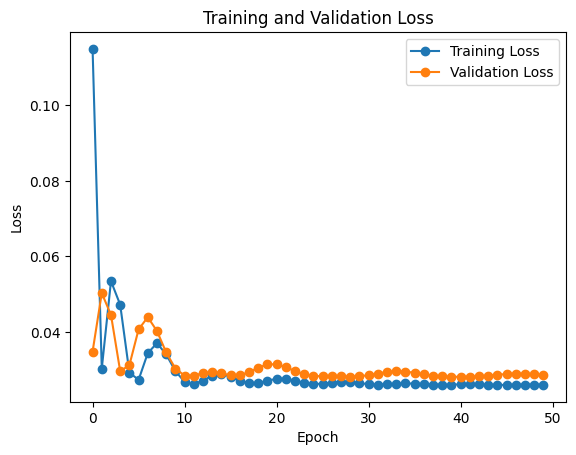

In [27]:
# Plot training and validation loss with markers
plt.plot(training_loss, marker='o', label='Training Loss')
plt.plot(validation_loss, marker='o', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [28]:
# Evaluation on validation data
val_prediction, _ = best_model(x_val.float())
val_loss = mse_loss(val_prediction, y_val.float())
print(f'MSE on validation data: {val_loss.item()}')

# Evaluation on test data
test_prediction, _ = best_model(x_test.float())
test_loss = mse_loss(test_prediction, y_test.float())
print(f'MSE on test data: {test_loss.item()}')

MSE on validation data: 0.028076298534870148
MSE on test data: 0.010473026894032955


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([300, 1, 1])) that is different to the input size (torch.Size([300, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Evaluation

In [29]:
best_model.eval()

RNN(
  (rnn): RNN(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)

In [30]:
# hist backward
_, h_list = best_model(x_val.float())
h_list

tensor([[ 0.2455, -0.1747,  0.1312,  ...,  0.0818,  0.1236, -0.5930],
        [ 0.2509, -0.1812,  0.1346,  ...,  0.0794,  0.1271, -0.5899],
        [ 0.2518, -0.1796,  0.1307,  ...,  0.0797,  0.1168, -0.5828],
        ...,
        [ 0.1202, -0.1039,  0.0988,  ...,  0.1394, -0.0034, -0.5657],
        [ 0.1119, -0.0942,  0.0890,  ...,  0.1429, -0.0268, -0.5571],
        [ 0.0894, -0.0868,  0.0867,  ...,  0.1528, -0.0486, -0.5489]],
       grad_fn=<SelectBackward0>)

In [31]:
# warm hidden state --> Last output by model
h = (h_list[-1, :]).unsqueeze(-2)
h

tensor([[ 0.0894, -0.0868,  0.0867, -0.0342,  0.1889,  0.1358, -0.1380, -0.2459,
          0.2153,  0.1528, -0.0486, -0.5489]], grad_fn=<UnsqueezeBackward0>)

In [32]:
# initialize
predicted = []

# iteration test
for test_seq in x_test.tolist():

    # change list to tensor then obtain 1 dimention
    x = torch.Tensor(data = [test_seq])

    # passing hidden state through each iteration --> remember iteration previous
    y, h = best_model(x, h.unsqueeze(-2))

    # back to real scaler
    unscaled = scaler.inverse_transform(np.array(y.item()).reshape(-1, 1))[0][0]

    predicted.append(unscaled)

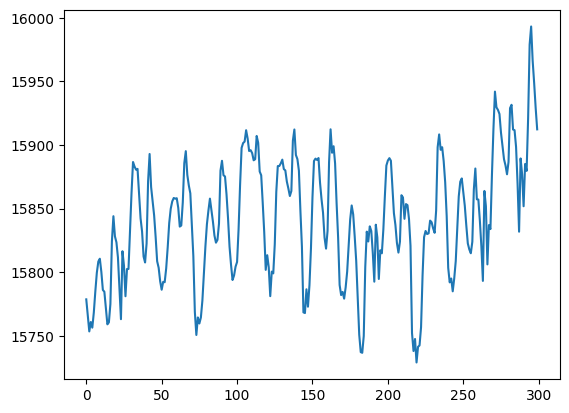

In [33]:
plt.plot(predicted)

In [47]:
# sanichek
real = scaler.inverse_transform(y_test.reshape(-1, 1))
len(predicted)
len(y_test)

300

In [45]:
# min max
print('Predict')
print(min(predicted))
print(max(predicted))

print('y_test')
print(real.max())
print(real.min())

Predict
15728.961074292662
15993.13299366832
y_test
21109.0
13064.0


Performance on data test

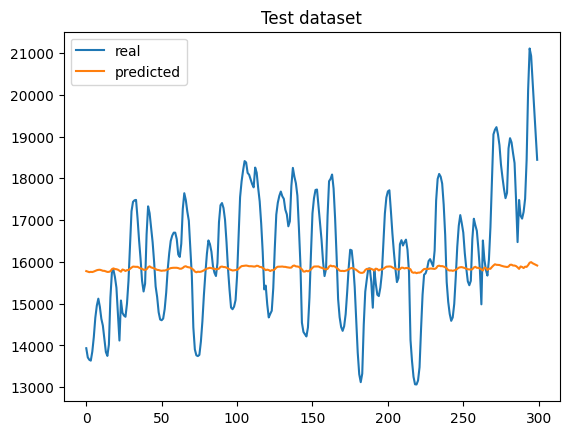

In [35]:
plt.title("Test dataset")
plt.plot(real, label = 'real')
plt.plot(predicted, label = 'predicted')
plt.legend()
plt.show()

When we using this model, is not good. We can using other model